In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from xgboost import XGBRegressor
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from xgboost import XGBClassifier, plot_importance
import uuid 
plt.rcParams['figure.dpi'] = 72


In [9]:
a = uuid.uuid1()

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
pcs = pd.read_csv('data/pcs.csv')

In [12]:
pcs.head()

,survey_year,program_category,region_served,age_group,sex,transgender,sexual_orientation,hispanic_ethnicity,race,living_situation,household_composition,preferred_language,veteran_status,employment_status,number_of_hours_worked_each_week,education_status,special_education_services,mental_illness,intellectual_disability,autism_spectrum,other_developmental_disability,alcohol_related_disorder,drug_substance_disorder,mobility_impairment_disorder,hearing_visual_impairment,hyperlipidemia,high_blood_pressure,diabetes,obesity,heart_attack,stroke,other_cardiac,pulmonary_asthma,alzheimer_or_dementia,kidney_disease,liver_disease,endocrine_condition,neurological_condition,traumatic_brain_injury,joint_disease,cancer,no_chronic_med_condition,unknown_chronic_med_condition,smokes,received_smoking_medication,received_smoking_counseling,serious_mental_illness,principal_diagnosis_class,additional_diagnosis_class,ssi_cash_assistance,ssdi_cash_assistance,veterans_disability_benefits,veterans_cash_assistance,public_assistance_cash_program,other_cash_benefits,medicaid_and_medicare_insurance,no_insurance,unknown_insurance_coverage,medicaid_insurance,medicaid_managed_insurance,medicare_insurance,private_insurance,child_health_plus_insurance,family_health_plus_insurance,other_insurance,criminal_justice_status,three_digit_residence_zip_code,other_chronic_med_condition
0,2013,SUPPORT,WESTERN REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,UNKNOWN,ENGLISH,NO,UNKNOWN EMPLOYMENT STATUS,NOT APPLICABLE,UNKNOWN,NOT APPLICABLE,YES,NO,UNKNOWN,NO,UNKNOWN,UNKNOWN,NO,NO,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,YES,NO,NO,NO,YES,UNKNOWN/DEFERRED,UNKNOWN/DEFERRED,UNKNOWN,UNKNOWN,NO,NO,NO,UNKNOWN,UNKNOWN,UNKNOWN,YES,UNKNOWN,NOT APPLICABLE,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,999,UNKNOWN
1,2013,OUTPATIENT,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ASIAN AND PACIFIC ISLAND,NO,EMPLOYED,35 HOURS OR MORE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,NO,NO,YES,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NOT APPLICABLE,NO,YES,NO,NO,NO,NO,112,UNKNOWN
2,2013,OUTPATIENT,WESTERN REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",BLACK ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,"UNEMPLOYED, LOOKING FOR WORK",NOT APPLICABLE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,UNKNOWN,NO,NO,NO,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,NO,146,UNKNOWN
3,2013,OUTPATIENT,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,NOT APPLICABLE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,YES,MENTAL ILLNESS,MENTAL ILLNESS,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,103,UNKNOWN
4,2013,OUTPATIENT,CENTRAL NY REGION,CHILD,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,NOT APPLICABLE,PRE-K TO FIFTH GRADE,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,YES,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,NO,137,UNKNOWN


In [13]:
pcs.drop("survey_year", axis=1, inplace=True)

In [14]:
pcs.shape

(546492, 67)

Lets check out how many people on this sruvey has mental illness

In [15]:
pcs['mental_illness'].value_counts(normalize=True)

YES        0.949670
NO         0.040709
UNKNOWN    0.009621
Name: mental_illness, dtype: float64

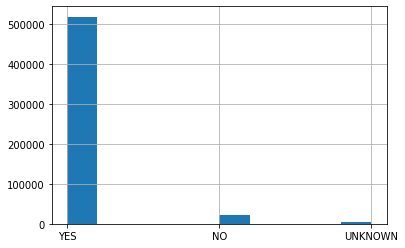

In [16]:
pcs['mental_illness'].hist()

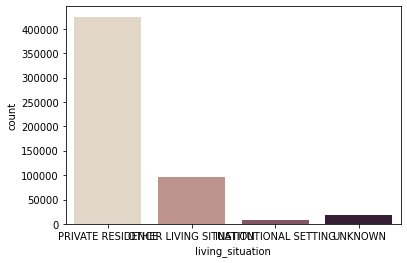

In [125]:
sns.countplot(x="living_situation", palette="ch:.25", data=pcs, )

The overwheming majority huh......

In [18]:
pcs['age_group'].value_counts(normalize=True)

ADULT      0.797600
CHILD      0.202241
UNKNOWN    0.000159
Name: age_group, dtype: float64

Children account for approximately 18 percent of mental illness patients

In [35]:
fem = pcs[pcs['sex']=="FEMALE"].copy()
mle = pcs[pcs['sex']=="MALE"].copy()
pcs['sex'].value_counts(normalize=True)

FEMALE     0.500055
MALE       0.493226
UNKNOWN    0.006719
Name: sex, dtype: float64

In [40]:
mle['mental_illness'].value_counts(normalize=True)

YES        0.951778
NO         0.038721
UNKNOWN    0.009501
Name: mental_illness, dtype: float64

In [39]:
fem['mental_illness'].value_counts(normalize=True)

YES        0.950943
NO         0.039469
UNKNOWN    0.009587
Name: mental_illness, dtype: float64

In [42]:
ssi_no = pcs[pcs['ssi_cash_assistance']=="NO"]
ssi_yes = pcs[pcs['ssi_cash_assistance']=="YES"]
pcs['ssi_cash_assistance'].value_counts(normalize=True)

NO         0.563242
YES        0.343302
UNKNOWN    0.093456
Name: ssi_cash_assistance, dtype: float64

In [43]:
ssi_no['mental_illness'].value_counts(normalize=True)

YES        0.935632
NO         0.058494
UNKNOWN    0.005874
Name: mental_illness, dtype: float64

In [44]:
ssi_yes['mental_illness'].value_counts(normalize=True)

YES        0.986259
NO         0.011268
UNKNOWN    0.002473
Name: mental_illness, dtype: float64

In [9]:
blk = pcs[pcs['race']=="black"].copy()
white = pcs[pcs['race']=="white"]
pcs['race'].value_counts(normalize=True)


WHITE ONLY      0.509215
BLACK ONLY      0.259497
OTHER           0.169386
UNKNOWN RACE    0.030992
MULTI-RACIAL    0.030910
Name: race, dtype: float64

In [15]:
blk = pcs[pcs['race']=="BLACK ONLY"]
blk['mental_illness'].value_counts(normalize=True)

YES        0.958699
NO         0.033523
UNKNOWN    0.007778
Name: mental_illness, dtype: float64

In [27]:
oth = pcs[pcs['race']=="OTHER"]
oth['mental_illness'].value_counts(normalize=True)

YES        0.951474
NO         0.042261
UNKNOWN    0.006266
Name: mental_illness, dtype: float64

In [28]:
mr = pcs[pcs['race']=="MULTI-RACIAL"]
mr['mental_illness'].value_counts(normalize=True)

YES        0.961520
NO         0.033862
UNKNOWN    0.004618
Name: mental_illness, dtype: float64

In [18]:
white = pcs[pcs['race']=="WHITE ONLY"]
white['mental_illness'].value_counts(normalize=True)

YES        0.949328
NO         0.040908
UNKNOWN    0.009763
Name: mental_illness, dtype: float64

In [25]:
his = pcs[(pcs['hispanic_ethnicity']=="YES, HISPANIC/LATINO") | (pcs['hispanic_ethnicity']=='YES')]

In [26]:
his['mental_illness'].value_counts(normalize=True)

YES        0.950706
NO         0.042761
UNKNOWN    0.006533
Name: mental_illness, dtype: float64

In [21]:
pcs['hispanic_ethnicity'].value_counts(normalize=True)

NO, NOT HISPANIC/LATINO    0.746384
YES, HISPANIC/LATINO       0.154860
YES                        0.075366
UNKNOWN                    0.023389
Name: hispanic_ethnicity, dtype: float64

In [191]:
pcs['transgender'].value_counts(normalize=True)


NO, NOT TRANSGENDER     0.960757
UNKNOWN                 0.027898
YES, TRANSGENDER        0.006593
CLIENT DIDN'T ANSWER    0.004752
Name: transgender, dtype: float64

In [34]:
trn['mental_illness'].value_counts(normalize=True)

YES        0.970025
NO         0.023036
UNKNOWN    0.006939
Name: mental_illness, dtype: float64

In [31]:
trn = pcs[pcs['transgender']=="YES, TRANSGENDER"]

In [45]:
pcs['program_category'].value_counts(normalize=True)


OUTPATIENT     0.659095
RESIDENTIAL    0.147429
SUPPORT        0.123566
INPATIENT      0.051097
EMERGENCY      0.018813
Name: program_category, dtype: float64

In [54]:
emr = pcs[pcs['program_category']=='EMERGENCY']
dis_emr = pcs[pcs['program_category']!='EMERGENCY']

In [ ]:
dis_emr

In [58]:
emr['mental_illness'].value_counts(normalize=True)

YES        0.826865
NO         0.115650
UNKNOWN    0.057485
Name: mental_illness, dtype: float64

In [57]:
dis_emr['mental_illness'].value_counts(normalize=True)

YES        0.952024
NO         0.039272
UNKNOWN    0.008704
Name: mental_illness, dtype: float64

In [22]:
pcs['serious_mental_illness'].value_counts(normalize=True)

YES        0.843141
NO         0.150147
UNKNOWN    0.006712
Name: serious_mental_illness, dtype: float64

Strangely enough, 84.3 percent of respondants have a serious mental illness, along with 94.9 percent who havve a mental illness. * note this is a data leakage issue in future modeling 

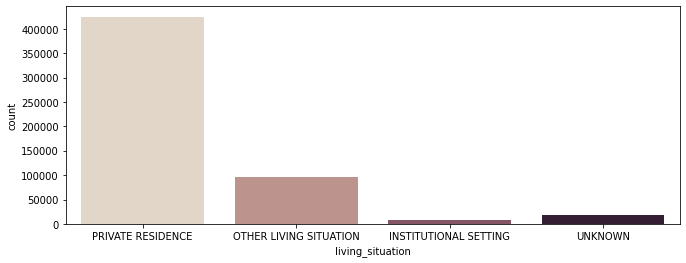

In [23]:
f, axes = plt.subplots( sharey=True, figsize=(11, 4))
sns.countplot(x="living_situation", palette="ch:.25", data=pcs, )

In [24]:
pcs['living_situation'].value_counts(normalize=True)

PRIVATE RESIDENCE         0.776853
OTHER LIVING SITUATION    0.176370
UNKNOWN                   0.032784
INSTITUTIONAL SETTING     0.013993
Name: living_situation, dtype: float64

Most live in a private residence, but the second largest feature is other. With little info on that, I become curious as to the true state of 20% of the respondants

Text(0, 0.5, 'Living Status')

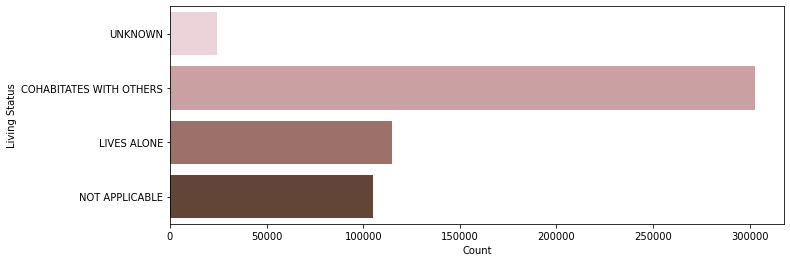

In [25]:
f, axes = plt.subplots( sharey=True, figsize=(11, 4))
sns.countplot(y="household_composition", palette="ch:1.3,-.2,dark=.3", data=pcs, )
plt.xlabel("Count")
plt.ylabel("Living Status")

Text(0.5, 0, 'Count')

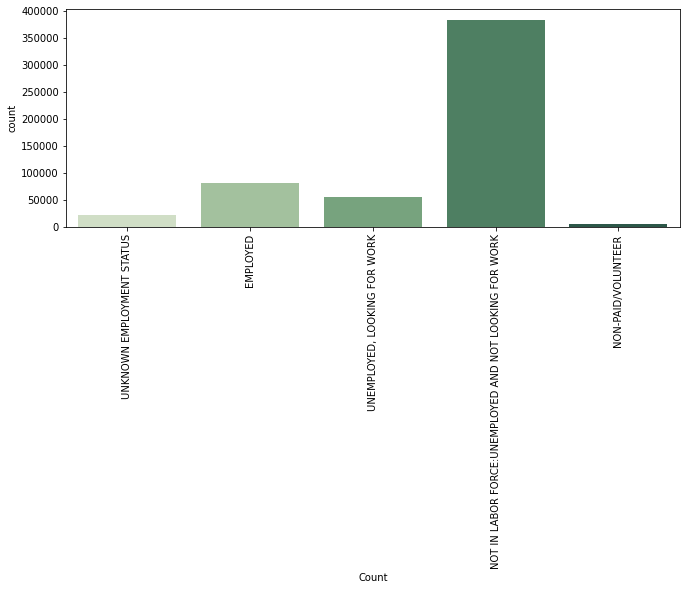

In [50]:
f, axes = plt.subplots( sharey=True, figsize=(11, 4))
plt.xticks(rotation='vertical')
sns.countplot(x="employment_status", palette="ch:2.5,-.3,dark=.3", data=pcs)
plt.xlabel("Count")
# plt.ylabel("Employment Status")

In [48]:
# pcs['three_digit_residence_zip_code'].value_counts(normalize=True)


Text(0, 0.5, 'Count')

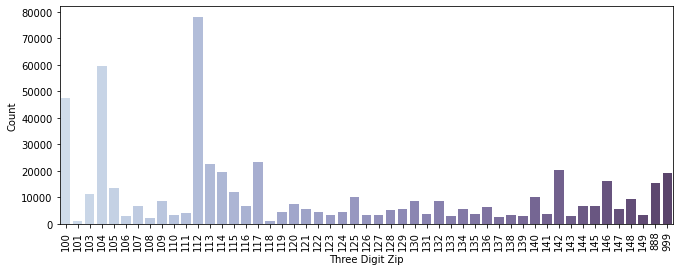

In [126]:

f, axes = plt.subplots( sharey=True, figsize=(11, 4))
plt.xticks(rotation='vertical')

sns.countplot(x="three_digit_residence_zip_code", palette="ch:3.5,-.3,dark=.3", data=pcs, )
plt.xlabel("Three Digit Zip")
plt.ylabel("Count")

In [29]:
 l = pcs['three_digit_residence_zip_code'].value_counts(normalize=True)

In [30]:
l.head(2).sum()

0.2519250053065736

Almost 25% of the group are accounted for with two zipcodes. With a wikipedia search, we see that comprises Brooklyn and The Bronx.

In [60]:
pcs['id'] = [ uuid.uuid1()  for k in pcs.index]

In [61]:
target = 'serious_mental_illness'
X = pd.DataFrame(pcs.drop(columns=[target,'mental_illness', 'principal_diagnosis_class', 'additional_diagnosis_class' ]))
y = pd.DataFrame(pcs[target])

In [62]:
X.shape

(546492, 64)

In [63]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, 
    y, 
    test_size=0.001,
    train_size=0.10, 
    stratify=y, 
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, 
    y_trainval, 
    test_size=0.05,
    train_size=0.10, 
    stratify=y_trainval, 
    random_state=42
)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (5464, 64)
y_train shape (5464, 1)
X_val shape (2733, 64)
y_val shape (2733, 1)
X_test shape (547, 64)
y_test shape (547, 1)


In [192]:
5464 + 2733 + 547

8744

In [193]:
pcs.shape

(546492, 68)

In [194]:
8744/546492

0.016000234221177988

In [195]:

0.016000234221177988 * 100

1.6000234221177987

In [64]:
train_id = X_train['id']
val_id = X_val['id']
test_id = X_test['id']

X_train = X_train.drop('id', axis=1)
X_val= X_val.drop('id', axis=1)
X_test= X_test.drop('id', axis=1)

In [65]:
x_processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

y_processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [66]:
cols = X_train.columns
len(cols)

63

In [67]:
def prepare_inputs(X_train, X_val, X_test):
	X_train_enc = pd.DataFrame(x_processor.fit_transform(X_train), columns=cols)
	X_val_enc = pd.DataFrame(x_processor.transform(X_val), columns=cols)
	X_test_enc = pd.DataFrame(x_processor.transform(X_test), columns=cols)
	return X_train_enc, X_val_enc, X_test_enc

def prepare_targets(y_train, y_val, y_test):
    y_train_enc = pd.DataFrame(y_processor.fit_transform(y_train), columns=['serious_mental_illness'])
    y_val_enc = pd.DataFrame(y_processor.transform(y_val), columns=['serious_mental_illness'])
    y_test_enc = pd.DataFrame(y_processor.transform(y_test), columns=['serious_mental_illness'])
    return y_train_enc, y_val_enc, y_test_enc

In [68]:
X_train_processed, X_val_processed, X_test = prepare_inputs(X_train, X_val, X_test)

In [69]:
X_train_processed.head()

,program_category,region_served,age_group,sex,transgender,sexual_orientation,hispanic_ethnicity,race,living_situation,household_composition,preferred_language,veteran_status,employment_status,number_of_hours_worked_each_week,education_status,special_education_services,intellectual_disability,autism_spectrum,other_developmental_disability,alcohol_related_disorder,drug_substance_disorder,mobility_impairment_disorder,hearing_visual_impairment,hyperlipidemia,high_blood_pressure,diabetes,obesity,heart_attack,stroke,other_cardiac,pulmonary_asthma,alzheimer_or_dementia,kidney_disease,liver_disease,endocrine_condition,neurological_condition,traumatic_brain_injury,joint_disease,cancer,no_chronic_med_condition,unknown_chronic_med_condition,smokes,received_smoking_medication,received_smoking_counseling,ssi_cash_assistance,ssdi_cash_assistance,veterans_disability_benefits,veterans_cash_assistance,public_assistance_cash_program,other_cash_benefits,medicaid_and_medicare_insurance,no_insurance,unknown_insurance_coverage,medicaid_insurance,medicaid_managed_insurance,medicare_insurance,private_insurance,child_health_plus_insurance,family_health_plus_insurance,other_insurance,criminal_justice_status,three_digit_residence_zip_code,other_chronic_med_condition
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,999.0,1.0
1,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,148.0,1.0
2,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,117.0,2.0
3,1.0,3.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,112.0,2.0
4,1.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,107.0,2.0


In [70]:
y_train_processed, y_val_processed, y_test_processed = prepare_targets(y_train, y_val, y_test)

In [71]:
y_train_processed.head()

,serious_mental_illness
0,1.0
1,1.0
2,2.0
3,2.0
4,2.0


In [181]:
num_of_classes = len(y.serious_mental_illness.unique())
num_of_classes

3

In [72]:
eval_set = [(X_train_processed, y_train_processed), (X_val_processed, y_val_processed)]

In [73]:
xgbcl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,  num_class=3,
         missing=None, n_jobs=-1, objective='multi:softprob', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto')

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

In [74]:
grid_search = GridSearchCV(estimator=xgbcl, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_processed, y_train_processed, eval_metric='mlogloss')

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

[07:00:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best: 0.8477308580043413 using {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.75} 



In [182]:
xgbcl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='multi:softprob', num_class=3,random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
         colsample_bytree = grid_result.best_params_['colsample_bytree'], 
         learning_rate = grid_result.best_params_['learning_rate'], 
         max_depth = grid_result.best_params_['max_depth'], 
         subsample = grid_result.best_params_['subsample'], 
         n_estimators = grid_result.best_params_['n_estimators'], eval_metric="auc")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#refit the model on k-folds to get stable avg error metrics
scores = cross_validate(estimator=xgbcl, X=X_train_processed, y=y_train_processed, cv=kfold, n_jobs=-1)

In [183]:
from sklearn import metrics
import joblib 
xgbcl.fit(X_train_processed, y_train_processed)


#Generate predictions against our training and test data
pred_train = xgbcl.predict(X_train_processed)
proba_train = xgbcl.predict_proba(X_train_processed)
pred_val = xgbcl.predict(X_val_processed)
proba_val = xgbcl.predict_proba(X_val_processed)
pred_test = xgbcl.predict(X_test)
proba_test = xgbcl.predict_proba(X_test)

[02:45:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [131]:
from joblib import dump, load
dump(xgbcl, 'xgbmodeal_v1_4.joblib')

['xgbmodeal_v1_4.joblib']

In [128]:
# clf = load('filename.joblib') 

In [129]:
# pred_train = clf.predict(X_train_processed)

In [184]:
print ('\nTrain loss:', metrics.log_loss(y_train_processed, proba_train))
print ('\nValidation loss:', metrics.log_loss(y_val_processed, proba_val))
print ('\nTest loss:', metrics.log_loss(y_test_processed, proba_test))


Train Accuracy: 0.26627737833969334

Validation Accuracy: 0.36565985119945216

Test Accuracy: 0.3623335865416464


In [185]:
print ('\nTrain Accuracy:', metrics.accuracy_score(y_train_processed, pred_train))
print ('\nValidation Accuracy:', metrics.accuracy_score(y_val_processed, pred_val))
print ('\nTest Accuracy:', metrics.accuracy_score(y_test_processed, pred_test))


Train Accuracy: 0.8857979502196194

Validation Accuracy: 0.8441273326015367

Test Accuracy: 0.850091407678245


In [94]:
print("Classification report (Test): \n")
print(metrics.classification_report(y_test_processed, pred_test))

Classification report (Test): 

              precision    recall  f1-score   support

         1.0       0.64      0.09      0.15        82
         2.0       0.86      0.99      0.92       461
         3.0       0.50      0.25      0.33         4

    accuracy                           0.85       547
   macro avg       0.66      0.44      0.47       547
weighted avg       0.82      0.85      0.80       547



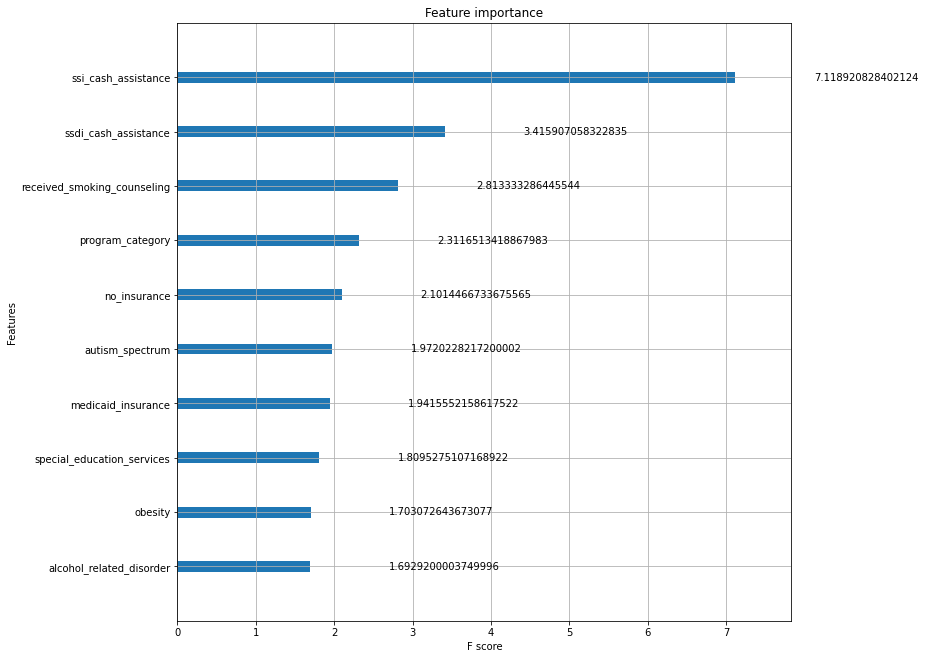

In [117]:
f, axes = plt.subplots( sharey=True, figsize=(11, 11))
plot_importance(xgbcl, ax=axes,importance_type='gain', max_num_features=10)

In [79]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [81]:
pcs.ssi_cash_assistance.value_counts(normalize=True)

NO         0.563242
YES        0.343302
UNKNOWN    0.093456
Name: ssi_cash_assistance, dtype: float64

In [103]:
pcs.ssdi_cash_assistance.value_counts(normalize=True)

NO         0.716442
YES        0.187774
UNKNOWN    0.095784
Name: ssdi_cash_assistance, dtype: float64

In [122]:
pcs.program_category.value_counts(normalize=True)


OUTPATIENT     0.659095
RESIDENTIAL    0.147429
SUPPORT        0.123566
INPATIENT      0.051097
EMERGENCY      0.018813
Name: program_category, dtype: float64

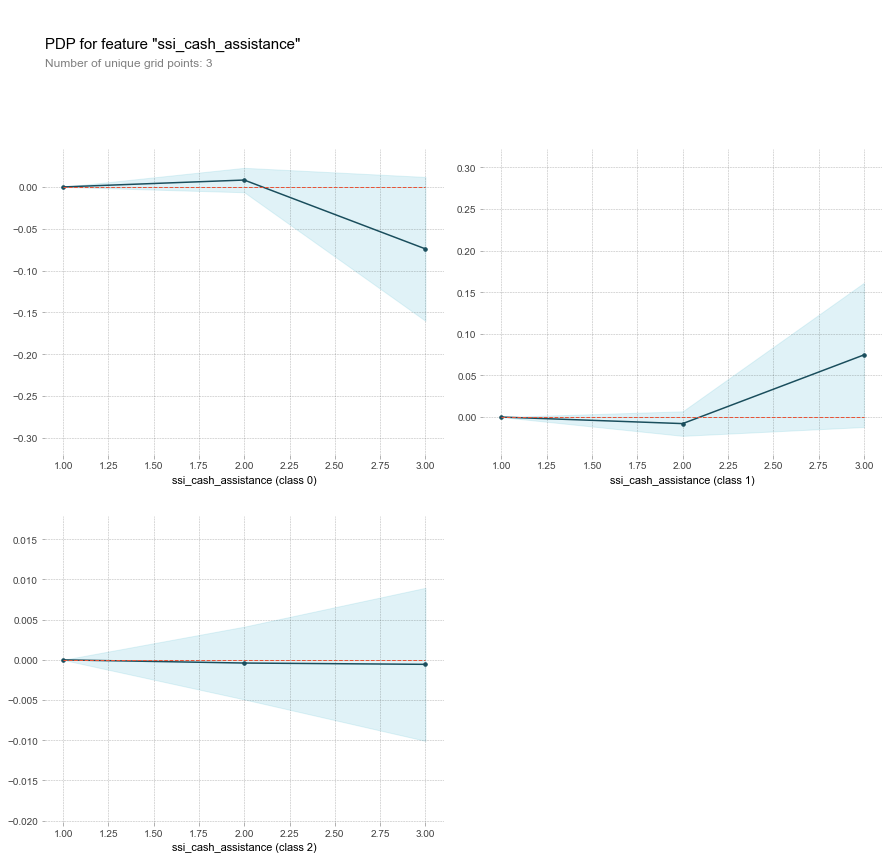

In [100]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='ssi_cash_assistance'
pdp_isolated = pdp_isolate(model=xgbcl, dataset=X_train_processed, 
                           model_features=X_train_processed.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x129683f10>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x128dd4190>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1284e9190>]})

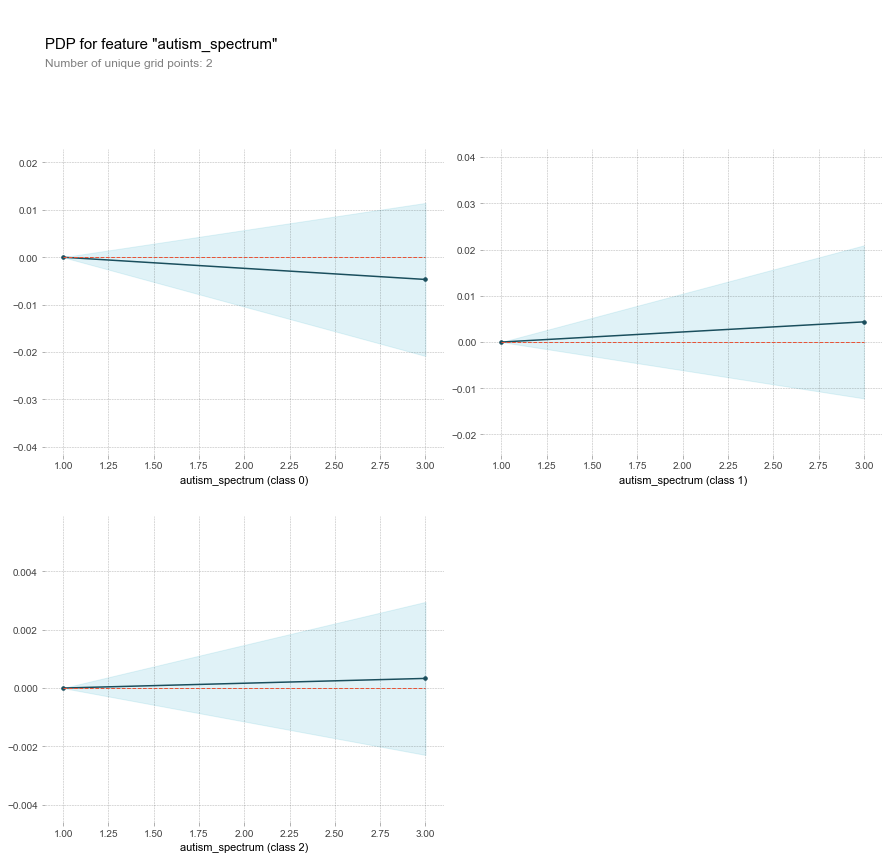

In [132]:

feature='autism_spectrum'
pdp_isolated = pdp_isolate(model=xgbcl, dataset=X_train_processed, 
                           model_features=X_train_processed.columns, feature=feature)
pdp_plot(pdp_isolated, feature)

In [134]:
pcs.received_smoking_counseling.value_counts(normalize=True)

NO         0.813412
YES        0.140533
UNKNOWN    0.046056
Name: received_smoking_counseling, dtype: float64

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13d1784d0>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x13debe590>,
   <matplotlib.axes._subplots.AxesSubplot at 0x13d178390>]})

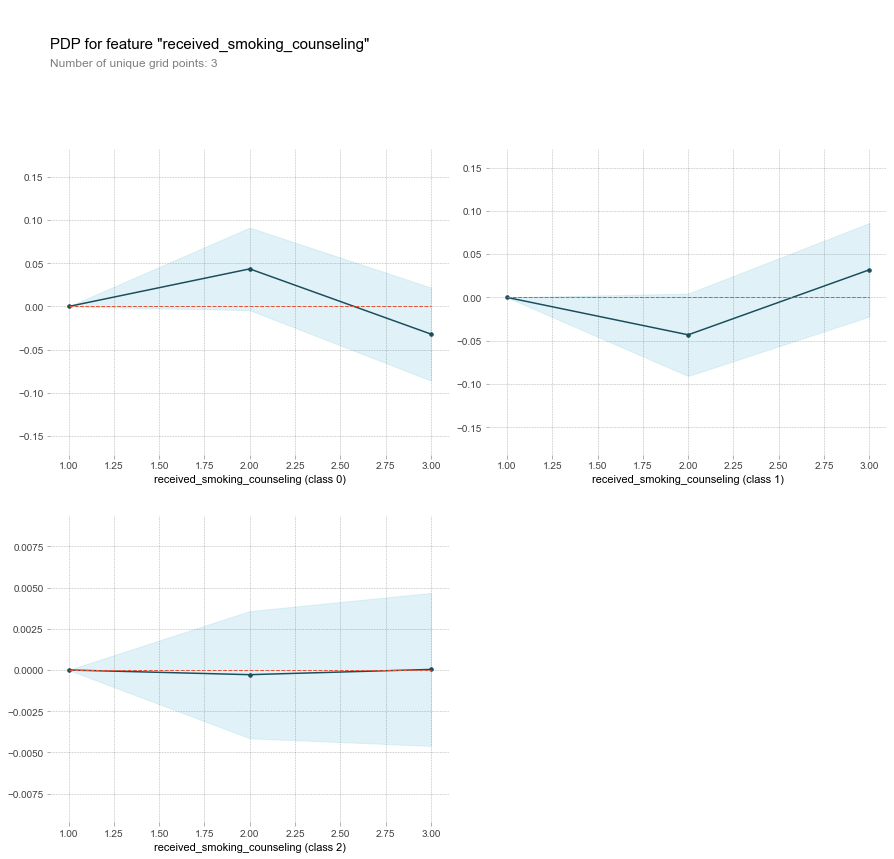

In [135]:

feature='received_smoking_counseling'
pdp_isolated = pdp_isolate(model=xgbcl, dataset=X_train_processed, 
                           model_features=X_train_processed.columns, feature=feature)
pdp_plot(pdp_isolated, feature)

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13e17acd0>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x13bbead50>,
   <matplotlib.axes._subplots.AxesSubplot at 0x13bbd8450>]})

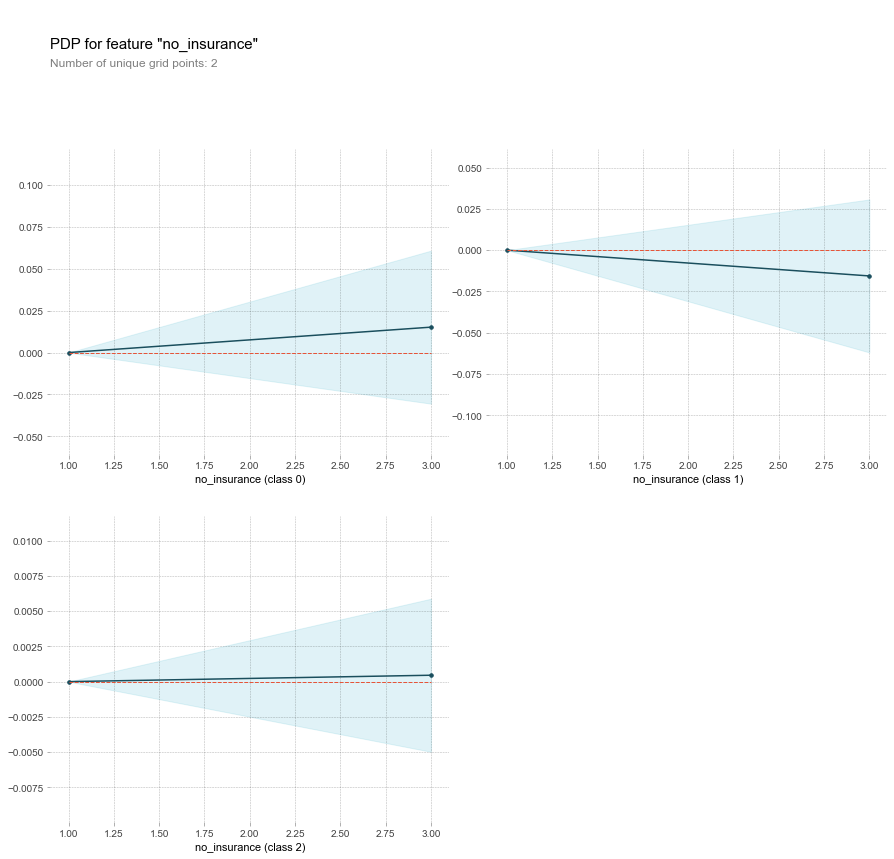

In [136]:

feature='no_insurance'
pdp_isolated = pdp_isolate(model=xgbcl, dataset=X_train_processed, 
                           model_features=X_train_processed.columns, feature=feature)
pdp_plot(pdp_isolated, feature)

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13cfabe10>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x13ceba3d0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x13cfab050>]})

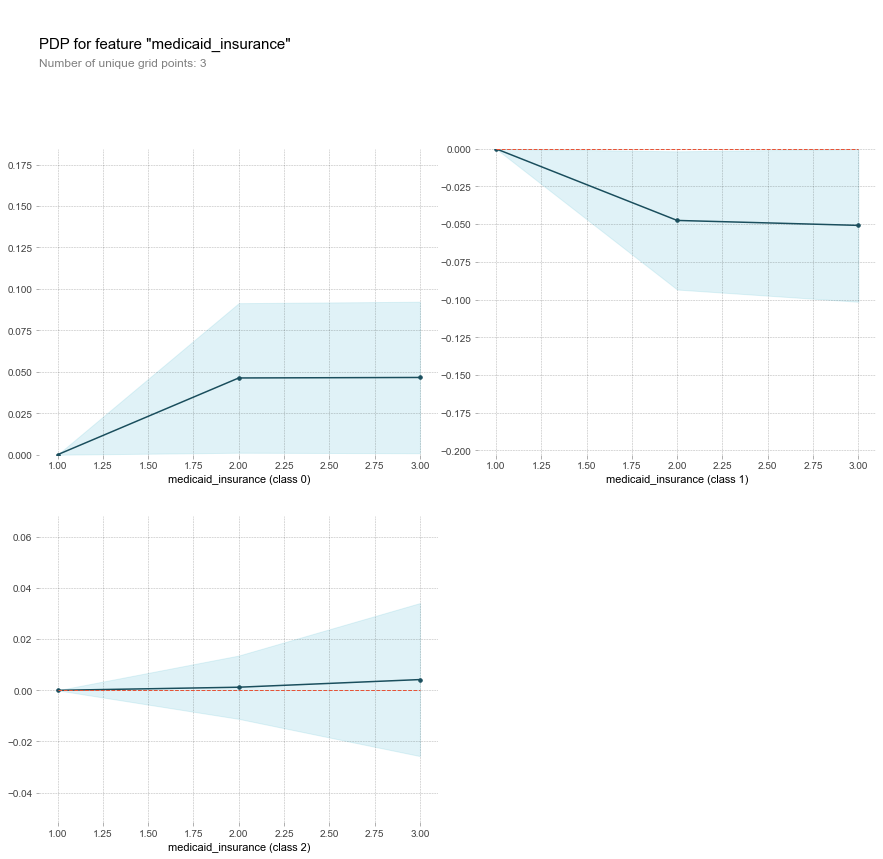

In [137]:

feature='medicaid_insurance'
pdp_isolated = pdp_isolate(model=xgbcl, dataset=X_train_processed, 
                           model_features=X_train_processed.columns, feature=feature)
pdp_plot(pdp_isolated, feature)

In [140]:
pcs.program_category.value_counts(normalize=True)

OUTPATIENT     0.659095
RESIDENTIAL    0.147429
SUPPORT        0.123566
INPATIENT      0.051097
EMERGENCY      0.018813
Name: program_category, dtype: float64

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1379edf50>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x1379fbdd0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1379ede90>]})

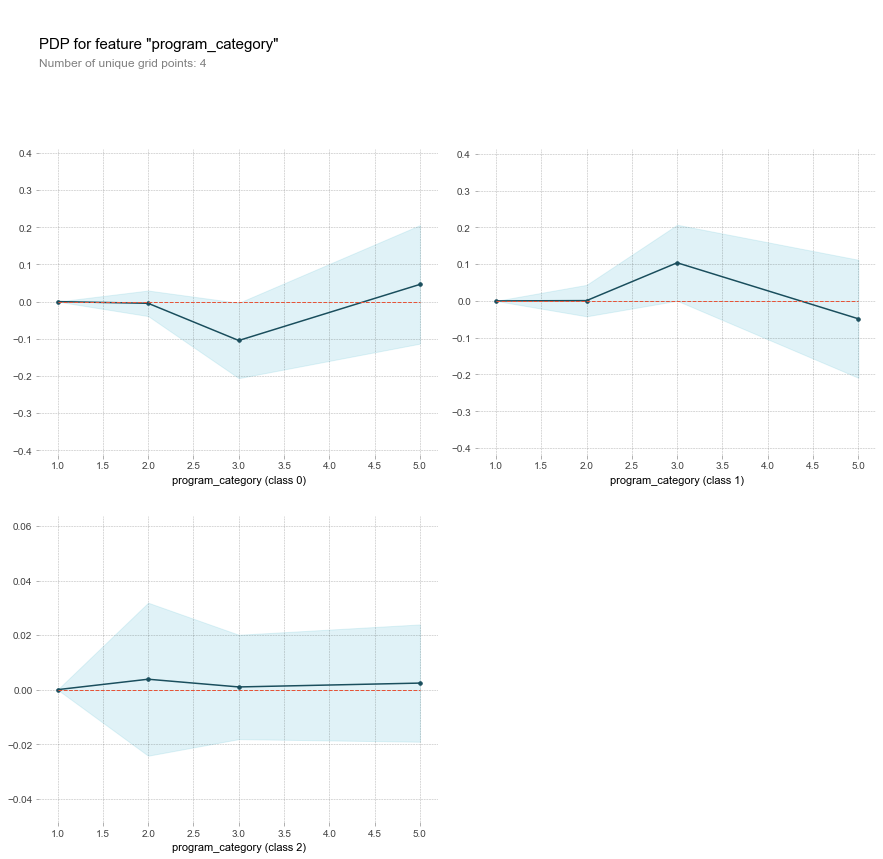

In [141]:

feature='program_category'
pdp_isolated = pdp_isolate(model=xgbcl, dataset=X_train_processed, model_features=X_train_processed.columns, feature=feature)
pdp_plot(pdp_isolated, feature)

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13e807fd0>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x13ec485d0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x13ec94350>]})

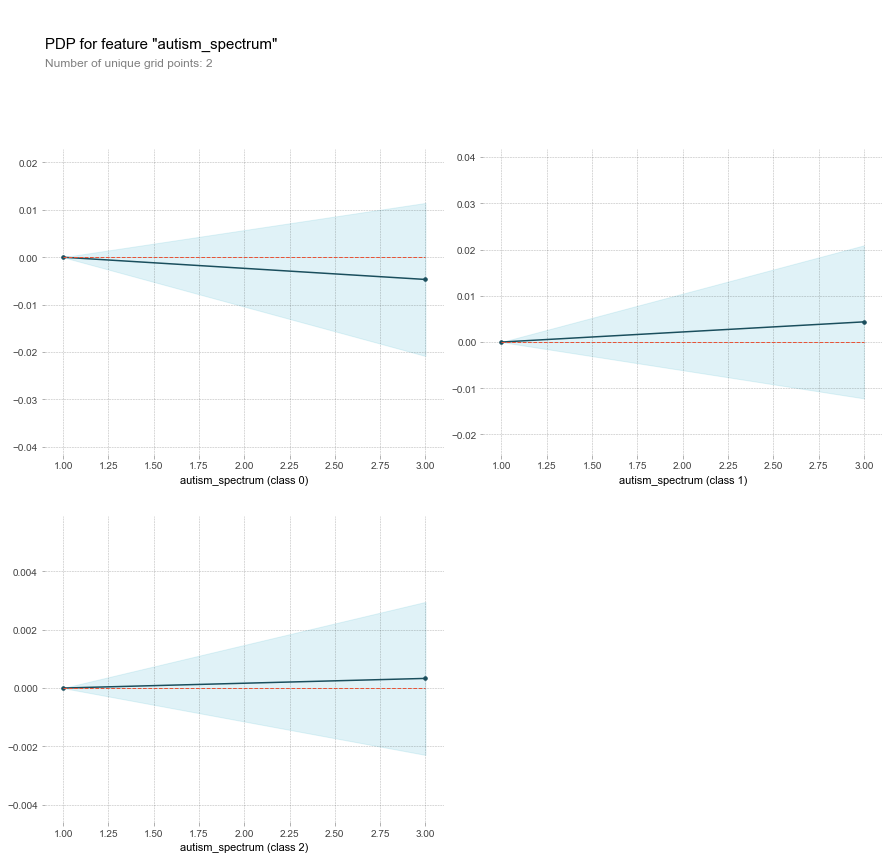

In [167]:

feature='autism_spectrum'
pdp_isolated = pdp_isolate(model=xgbcl, dataset=X_train_processed, model_features=X_train_processed.columns, feature=feature)
pdp_plot(pdp_isolated, feature)

In [171]:
res = pcs[pcs['program_category']=='RESIDENTIAL']

In [175]:
res.serious_mental_illness.value_counts(normalize=True)

YES        0.978006
NO         0.020479
UNKNOWN    0.001514
Name: serious_mental_illness, dtype: float64

In [178]:
non_res = pcs[pcs['program_category']!='RESIDENTIAL']

In [179]:
non_res.serious_mental_illness.value_counts(normalize=True)


YES        0.819820
NO         0.172569
UNKNOWN    0.007611
Name: serious_mental_illness, dtype: float64

In [157]:
X_train_processed.program_category.value_counts(normalize=True)

1.0    0.653001
3.0    0.150256
2.0    0.124085
4.0    0.052160
5.0    0.020498
Name: program_category, dtype: float64

In [158]:
X_train.program_category.value_counts(normalize=True)

OUTPATIENT     0.653001
RESIDENTIAL    0.150256
SUPPORT        0.124085
INPATIENT      0.052160
EMERGENCY      0.020498
Name: program_category, dtype: float64

In [156]:
y_train_processed.serious_mental_illness.value_counts(normalize=True)

2.0    0.843155
1.0    0.150073
3.0    0.006772
Name: serious_mental_illness, dtype: float64

In [160]:
y.serious_mental_illness.value_counts(normalize=True)

YES        0.843141
NO         0.150147
UNKNOWN    0.006712
Name: serious_mental_illness, dtype: float64

In [161]:
X_train_processed.ssi_cash_assistance.value_counts(normalize=True)

2.0    0.560944
3.0    0.341325
1.0    0.097731
Name: ssi_cash_assistance, dtype: float64

In [162]:
X_train.ssi_cash_assistance.value_counts(normalize=True)

NO         0.560944
YES        0.341325
UNKNOWN    0.097731
Name: ssi_cash_assistance, dtype: float64

In [149]:
features = ['program_category', 'ssi_cash_assistance']

interaction = pdp_interact(
    model=xgbcl,
    dataset=X_train_processed,
    model_features=X_train_processed.columns,
    features=features
)

(<Figure size 1080x1224 with 7 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13f2d7650>,
  'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x13e3f93d0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x13e4f3750>]})

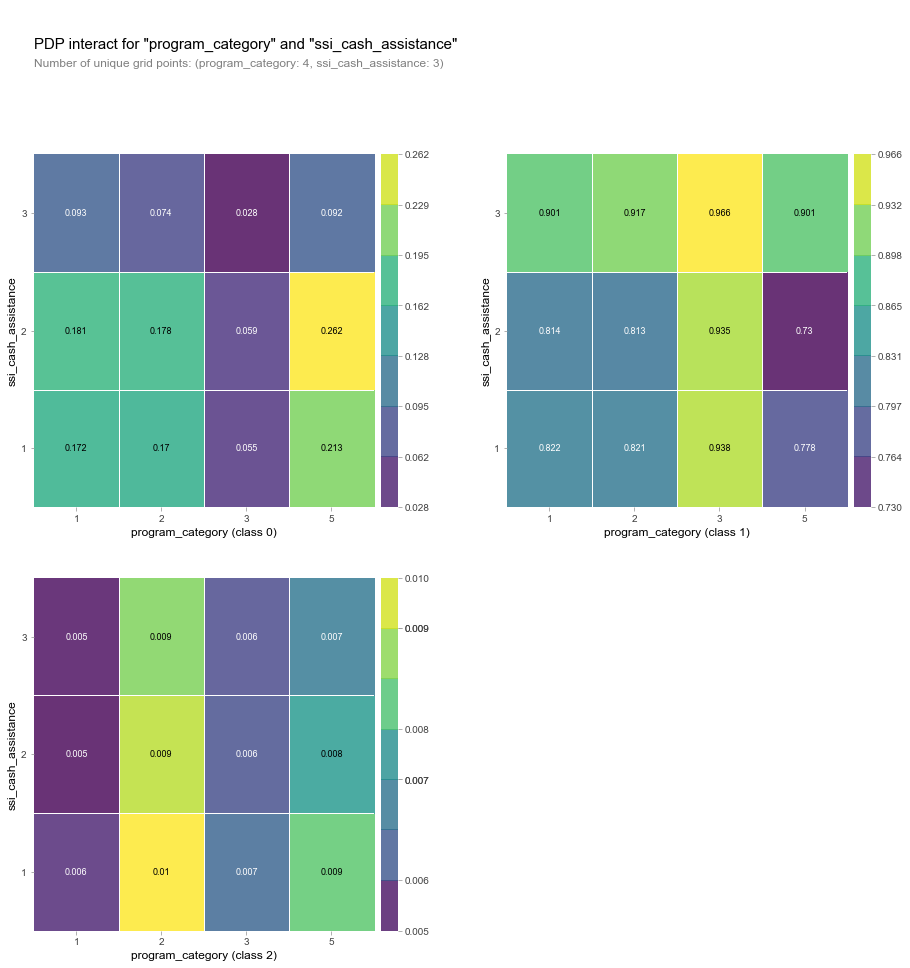

In [150]:
# looking at how top features intereact
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Serious Mental Illness, on program & ssi assistance')
pdp_interact_plot(interaction, plot_type='grid',feature_names=features)

In [164]:
X_train.autism_spectrum.value_counts(normalize=True)

NO         0.918009
UNKNOWN    0.062408
YES        0.019583
Name: autism_spectrum, dtype: float64

In [165]:
X_train_processed.autism_spectrum.value_counts(normalize=True)

1.0    0.918009
3.0    0.062408
2.0    0.019583
Name: autism_spectrum, dtype: float64

(<Figure size 1080x1224 with 7 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x14389c710>,
  'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x1438cd0d0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x142876590>]})

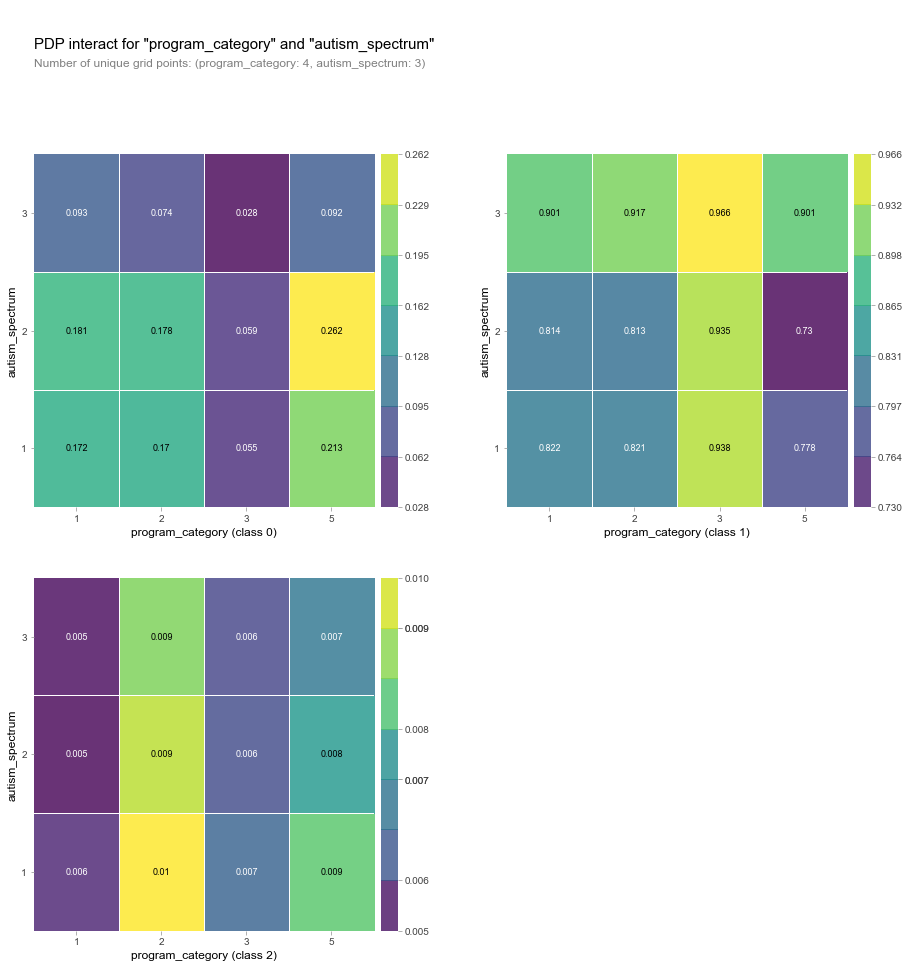

In [163]:
features = ['program_category', 'ssi_cash_assistance']

interaction = pdp_interact(
    model=xgbcl,
    dataset=X_train_processed,
    model_features=X_train_processed.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid',feature_names=features)


In [151]:
import shap

In [1]:


#Attempt to use SHAP on multi-class
X_rand = X.sample(1, random_state=42)
idx = X_rand.index.values[0]

#This line will not work for a multi-class model, so we comment out
#explainer = shap.TreeExplainer(mcl, model_output='probability', feature_dependence='independent', data=X)

explainer = shap.TreeExplainer(xgbcl)
shap_values = explainer.shap_values(X.iloc[idx])
shap.initjs()
for which_class in range(0,3):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))
    
#Display all features and SHAP values
df1=pd.DataFrame(data=shap_values[0], columns=X.columns, index=[0])
df2=pd.DataFrame(data=shap_values[1], columns=X.columns, index=[1])
df3=pd.DataFrame(data=shap_values[2], columns=X.columns, index=[2])
df=pd.concat([df1,df2,df3])
display(df.transpose())



NameError: name 'X' is not defined